In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import shap  
import h3

c:\Users\Yuan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)
h3_l7_df

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
173,872af6375ffffff,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2


In [3]:
train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

In [4]:
# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

print(len(train_index))
print(len(test_index))

83
94


In [5]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [6]:
window_size = 1
seed = 123 #7890
torch.manual_seed(seed)
np.random.seed(seed)

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)


        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-4, weight_decay=1e-5)

iter_num=5000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

100%|██████████| 5000/5000 [00:07<00:00, 646.61it/s]


In [7]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1]*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse

In [8]:
# mape_list = (y_head_test-y_test)/(test_spatial_data[:, -1].reshape(-1, 1)*h3_l7_df.ohca.max()+1)

# mape = mape_list[mape_list != np.inf].sum()/mape_list.shape[0]

mae = np.abs(y_head_test-y_test)
ans_mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',ans_mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

n = mae.shape[0]          # Number of data points
p = train_spatial_data.shape[1]            # Number of predictors

# Adjusted R-squared calculation
r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R² of test set= ", r_squared)
print("ADJ R² of test set= ", r_squared_adj)

MAE of test set=  5.583852468018836
R² of test set=  0.7586561695152917
ADJ R² of test set=  2.0202261925035394


# SHAP

In [9]:
# 假設 `spatial_data` 包含背景數據，用於 SHAP 的解釋
background_data = torch.FloatTensor(train_spatial_data[:, :-1])  
test_data = torch.FloatTensor(test_spatial_data[:, :-1])     

In [10]:
# 建立 SHAP 解釋器，使用背景數據
explainer = shap.GradientExplainer(s_net, background_data)
shap_values_test = explainer.shap_values(test_data)*ohca_reguli_inverse
# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]

feature_names = test_features_df.columns

In [11]:
shap_col = shap_values_test.shape[0]
shap_row = shap_values_test.shape[1]
shap_values_test_2D = shap_values_test.reshape(shap_col,shap_row)

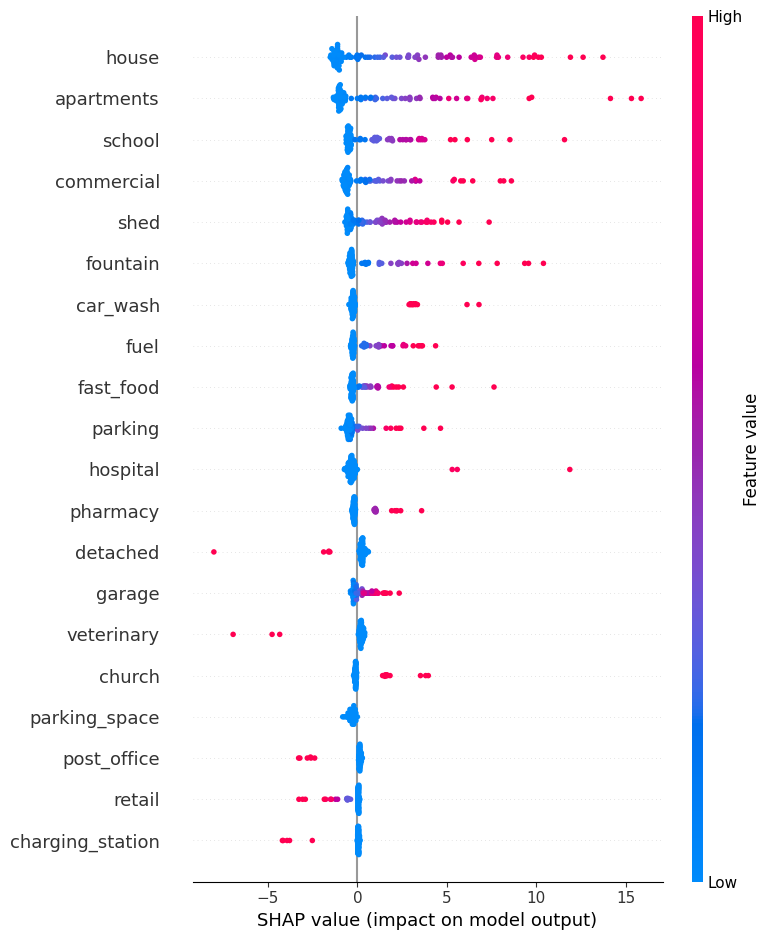

In [12]:
shap.summary_plot(shap_values_test_2D, test_data,feature_names)

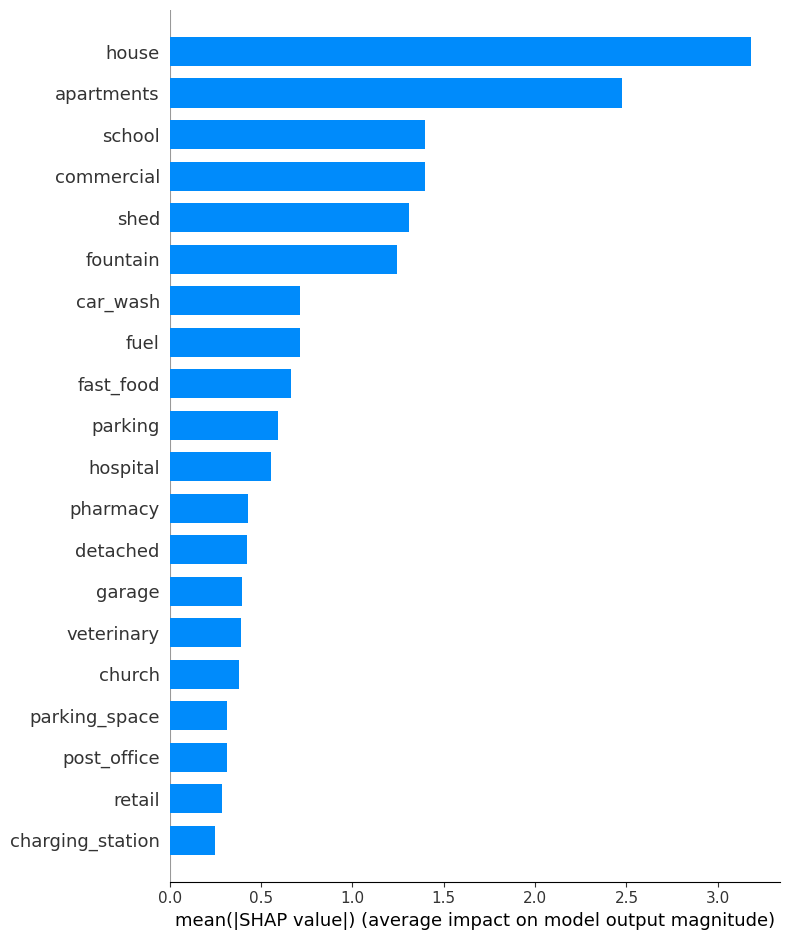

In [13]:
shap.summary_plot(shap_values_test_2D, test_data, plot_type="bar", class_names= 'OHCA', feature_names = feature_names)

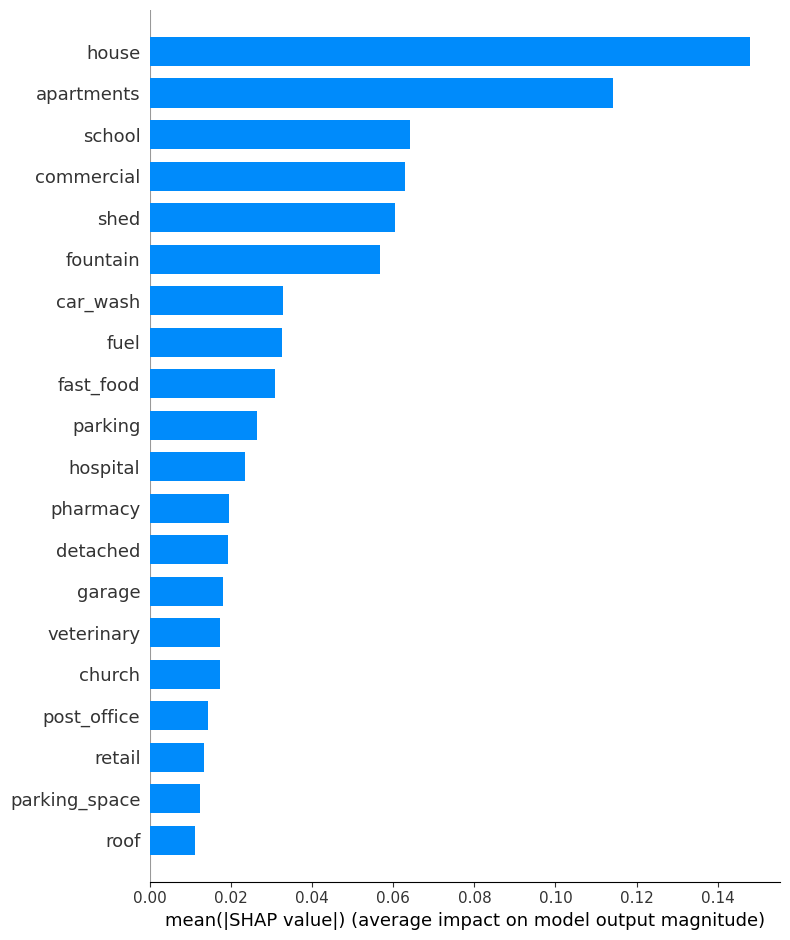

In [14]:
explainer = shap.GradientExplainer(s_net, background_data)
shap_values_test = explainer.shap_values(test_data)

shap_col = shap_values_test.shape[0]
shap_row = shap_values_test.shape[1]
shap_values_test_2D = shap_values_test.reshape(shap_col,shap_row)
# SHAP 特徵重要性：對每個特徵取絕對值的平均值
mean_abs_shap = np.abs(shap_values_test_2D).mean(axis=0)

# 歸一化：總和為 1
normalized_shap = shap_values_test_2D / np.sum(mean_abs_shap)
# shap_values_test = explainer.shap_values(X_test_reguli)

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(normalized_shap, test_data,feature_names , plot_type="bar",  max_display=20)

In [15]:
predicted_value_list = []
shap_predicted_value_list = []
for index in range(0,len(shap_values_test)):
# 轉換數據格式為 numpy
    shap_values_np = shap_values_test[index]  # SHAP 值
    base_value_np = s_net(background_data).mean().detach().item()*ohca_reguli_inverse #手算的ϕ0
    
    predicted_value = s_net(test_data[index]).detach().item()*ohca_reguli_inverse  # 模型的實際預測值
    shap_predicted_value = base_value_np + shap_values_np.sum()
    # print('f(x)= ' , predicted_value,'shap value= ' , shap_predicted_value)

    predicted_value_list.append(predicted_value)
    shap_predicted_value_list.append(shap_predicted_value)

predicted_value = np.array(predicted_value_list)
shap_predicted_value = np.array(shap_predicted_value_list)

shap_mae = np.abs(predicted_value-shap_predicted_value)
shap_ans_mae = shap_mae.sum()/shap_mae.shape[0]

print('MAE of test set= ',shap_ans_mae)

# 計算殘差變異
shap_ss_residual = np.sum((predicted_value - shap_predicted_value) ** 2)

# 計算總變異量
shap_ss_total = np.sum((predicted_value - np.mean(shap_predicted_value)) ** 2)

# 計算 R²
shap_r_squared = 1 - (shap_ss_residual / shap_ss_total)

print("R² of test set= ", shap_r_squared)

MAE of test set=  12.560903657633663
R² of test set=  0.021168557654244524


# using train data

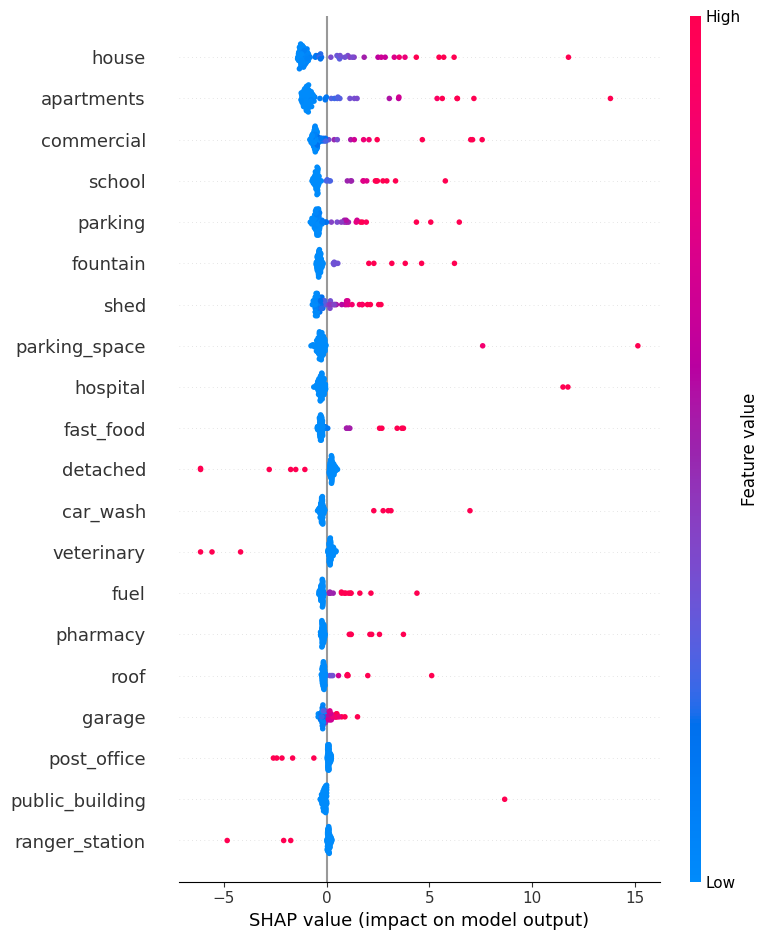

In [16]:
# 建立 SHAP 解釋器，使用背景數據
explainer = shap.GradientExplainer(s_net, background_data)
shap_values_train = explainer.shap_values(background_data)*ohca_reguli_inverse
# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]

feature_names = test_features_df.columns

shap_col_train = shap_values_train.shape[0]
shap_row_train = shap_values_train.shape[1]
shap_values_2D_train = shap_values_train.reshape(shap_col_train,shap_row_train)

shap.summary_plot(shap_values_2D_train, background_data,feature_names)

In [17]:
predicted_value_list = []
shap_predicted_value_list = []
base_value_np = y_head_train.mean()  # 手算的ϕ0

for index in range(0,len(shap_values_train)):
    # 轉換數據格式為 numpy
    shap_values_np = shap_values_train[index]  # SHAP 值
    predicted_value = y_head_train[index][0]  # 模型的實際預測值
    shap_predicted_value = base_value_np + shap_values_np.sum()
    predicted_value_list.append(predicted_value)
    shap_predicted_value_list.append(shap_predicted_value)

# 將列表轉換為NumPy數組
predicted_value_array = np.array(predicted_value_list)
shap_predicted_value_array = np.array(shap_predicted_value_list)

# 評估成效
train_mae = np.abs(predicted_value_array - shap_predicted_value_array)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of SHAP = ', train_ans_mae)


# 計算殘差變異
train_ss_residual = np.sum((predicted_value_array - shap_predicted_value_array) ** 2)
# 計算總變異量
train_ss_total = np.sum((predicted_value_array - np.mean(predicted_value_array)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

MAE of SHAP =  0.8209144798649369
R² of train set=  0.9940009989641222


Text(0, 0.5, "g(x')")

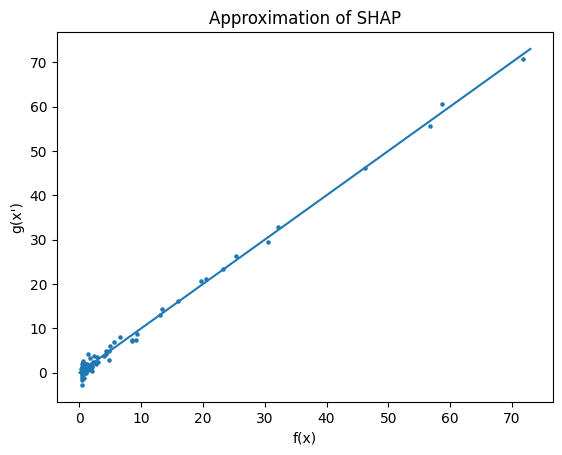

In [18]:
plt.scatter(predicted_value_list,
            shap_predicted_value_list,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Approximation of SHAP')
plt.xlabel('f(x)')
plt.ylabel("g(x')")

# 調整視窗大小和顯示feature數 

In [19]:
poi_df_A = pd.read_csv('OpenStreetMap/A_features.csv')
poi_df_A = poi_df_A[['osmid', 'amenity', 'geometry']]

poi_df_B = pd.read_csv('OpenStreetMap/B_features.csv')
poi_df_B = poi_df_B[['osmid','building', 'geometry','amenity']]



C:\Users\Yuan\AppData\Local\Temp\ipykernel_12688\2547229021.py:4: DtypeWarning: Columns (2,5,7,8,10,12,14,15,17,18,19,20,22,23,24,25,26,27,28,29,30,32,33,34,35,36,38,39,40,42,43,44,46,48,49,50,53,54,55,56,57,59,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,81,82,83,84,85,87,88,90,91,93,94,95,96,97,98,99,100,102,104,105,106,107,108,110,112,113,114,115,116,117,118,119,120,121,127,128,129,130,131,137,138,139,140,141,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,170,171,172,173,174,175,176,177,178,179,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,223,225,226,227,228,229,230,231,232,233,235,236,237,238,239,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df_B = pd.read_csv('OpenStreetMap/B_features.csv')


In [20]:
unique_valuesA = poi_df_A['amenity'].unique()
unique_valuesB = poi_df_B['building'].unique()
values_to_removeA = ['school', 'shelter', 'university', 'college', 'toilets', 'hospital']
unique_valuesA = [value for value in unique_valuesA if value not in values_to_removeA]
values_to_removeB = ['yes', 'hut','commercial;yes']
unique_valuesB = [value for value in unique_valuesB if value not in values_to_removeB]

print(len(unique_valuesA))
print(len(unique_valuesB))

76
39


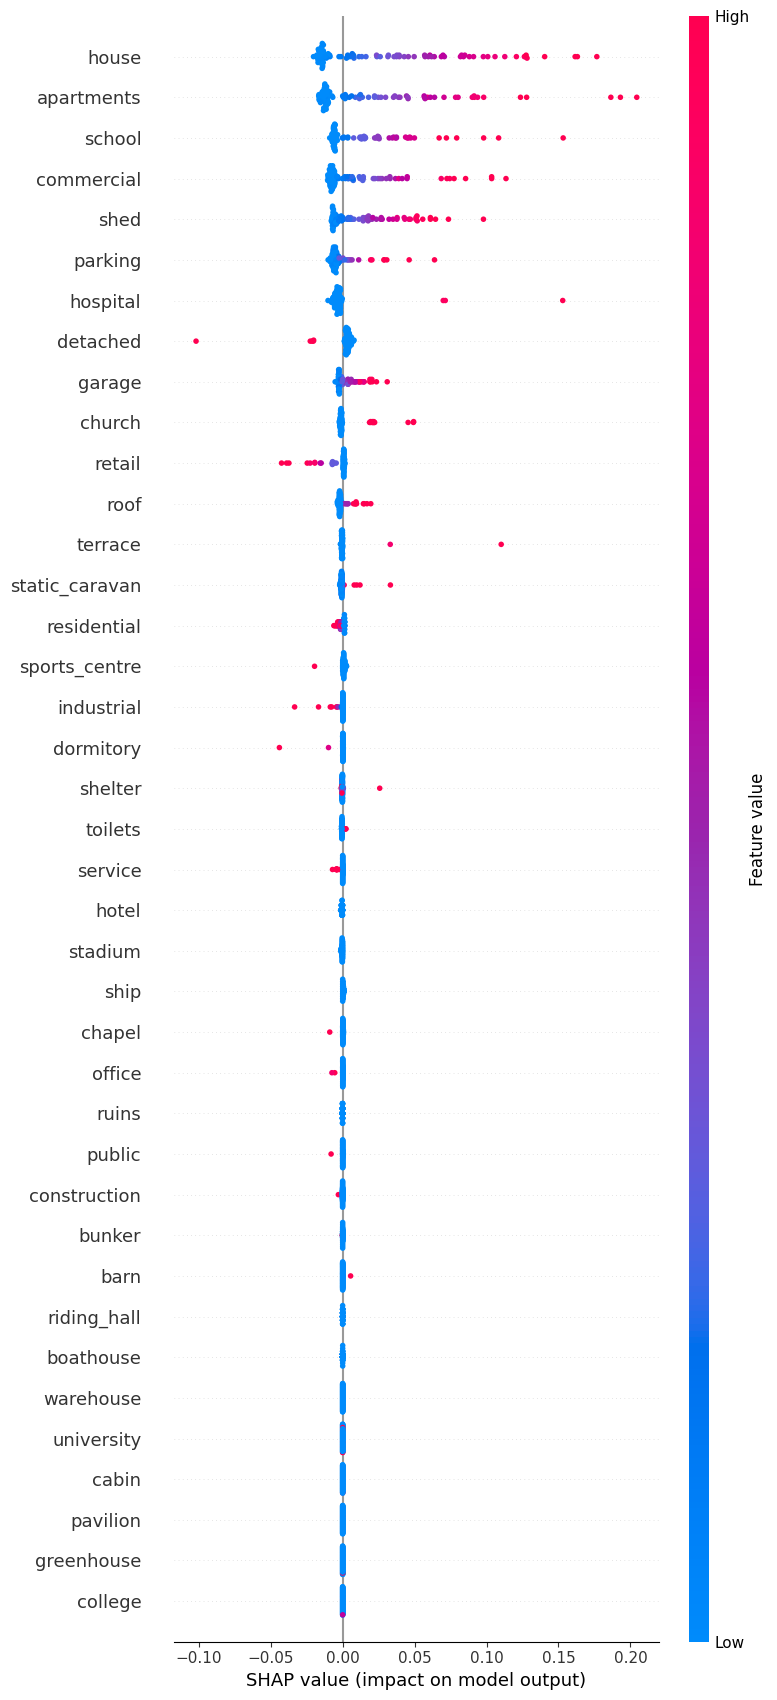

In [21]:
# 如果 feature_names 是 pandas.Index，轉換為列表
if isinstance(feature_names, pd.Index):
    feature_names = feature_names.tolist()
# 指定要顯示的特徵
selected_features = unique_valuesB

# 找到特徵索引
feature_indices = [feature_names.index(f) for f in selected_features]

# 篩選 shap_values 和 test_data
shap_values_filtered = shap_values_test_2D[:, feature_indices]
test_data_filtered = test_data[:, feature_indices]

# 繪製篩選後的 SHAP summary plot
shap.summary_plot(shap_values_filtered, test_data_filtered, selected_features , max_display=39)

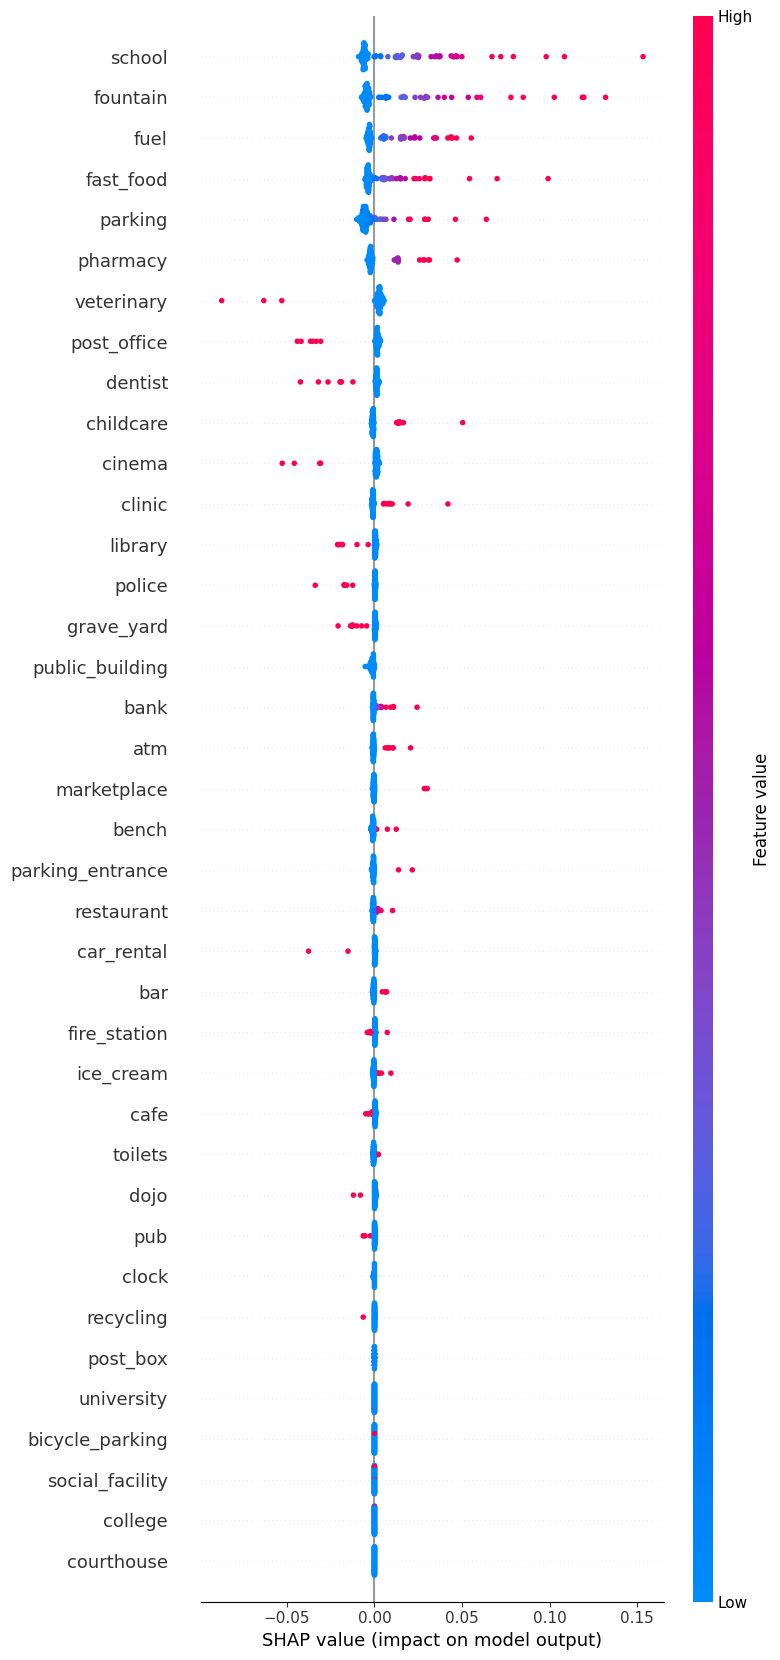

In [22]:
# 計算每個特徵的平均絕對 SHAP 值
mean_abs_shap_values = np.mean(np.abs(shap_values_filtered), axis=0)

# 找到排名後 39 個特徵的索引
sorted_indices = np.argsort(mean_abs_shap_values)  # 由小到大排序
selected_indices = sorted_indices[:38]  # 取排名後的 39 個特徵

# 篩選對應的 SHAP 值和資料
shap_values_filtered1 = shap_values_test_2D[:, selected_indices]
test_data_filtered1 = test_data[:, selected_indices]
selected_feature_names = [feature_names[i] for i in selected_indices]

# 繪製篩選後的 SHAP summary plot
shap.summary_plot(shap_values_filtered1, test_data_filtered1, selected_feature_names,max_display=38)

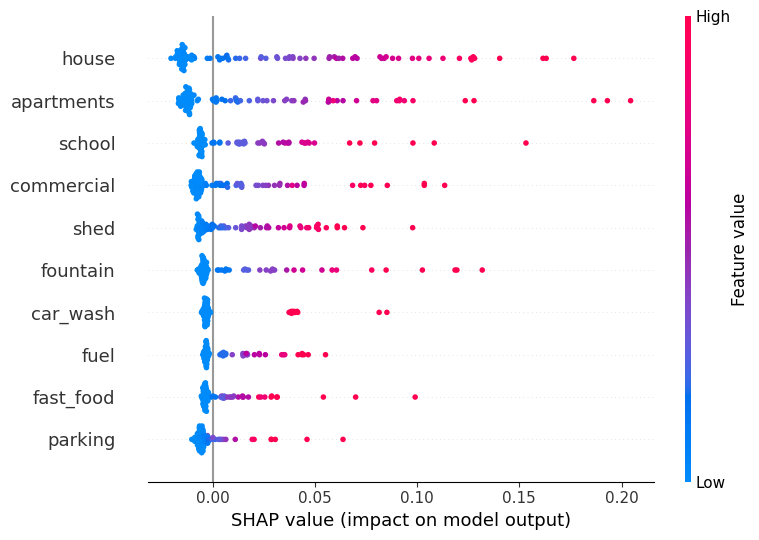

In [23]:
# 確保顯示10個特徵
shap.summary_plot(shap_values_test_2D, test_data, feature_names, max_display=10)

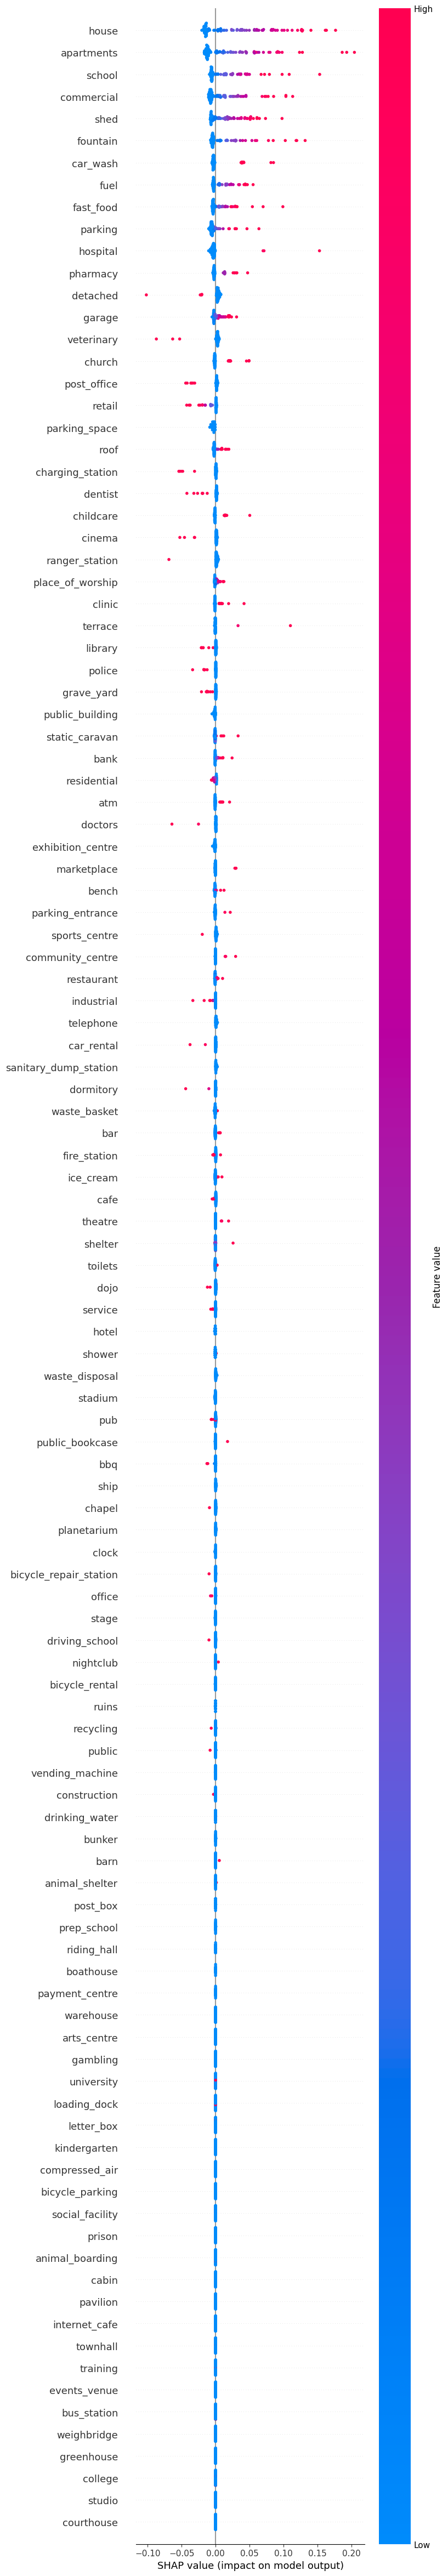

In [24]:
# 確保顯示所有特徵
shap.summary_plot(shap_values_test_2D, test_data, feature_names, max_display=test_data.shape[1])

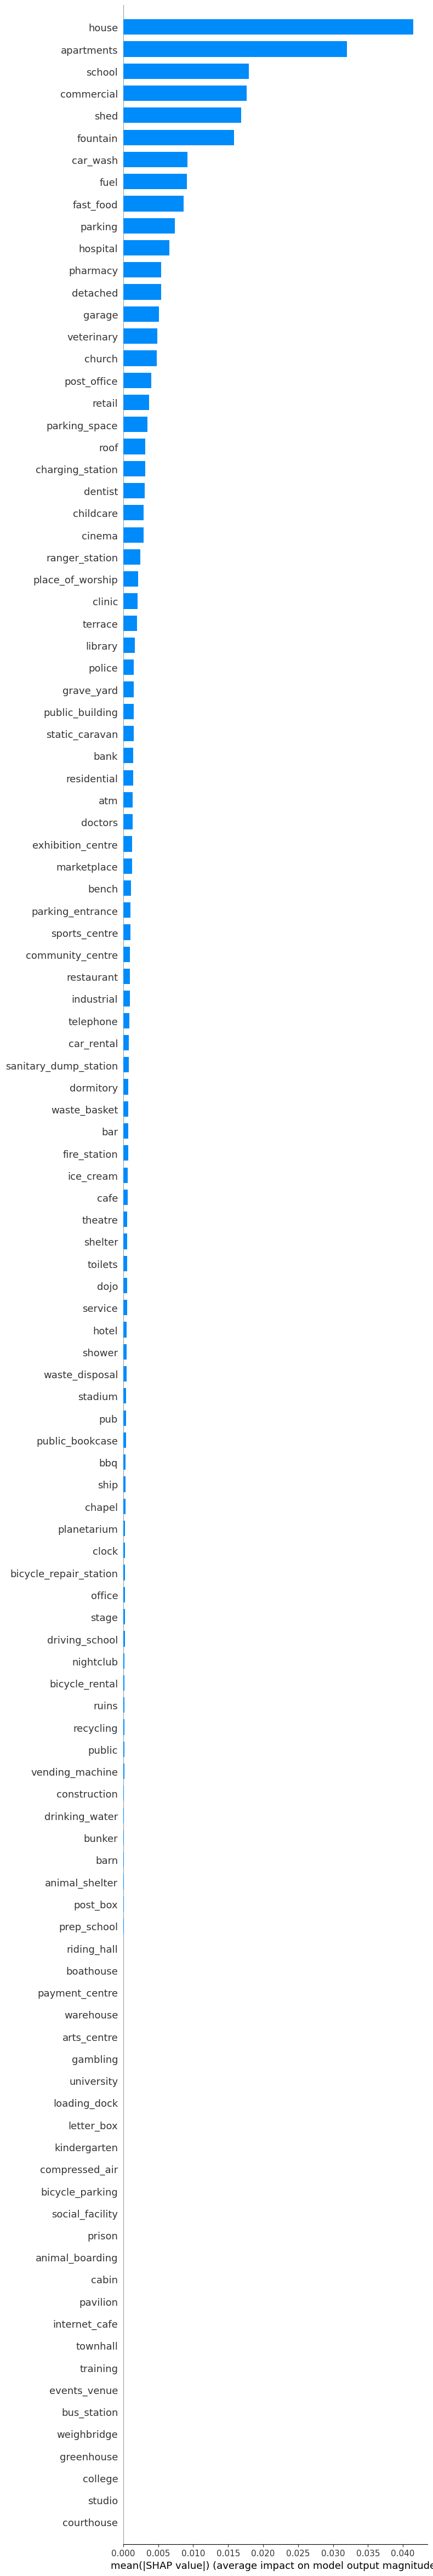

In [25]:
shap.summary_plot(shap_values_test_2D, test_data, plot_type="bar", class_names= 'OHCA', feature_names = feature_names,max_display=test_data.shape[1])